In [1]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy.kern import Kern
from GPy import Param, Model

In [2]:
class deepRBF(Kern):
    
    def __init__(self,input_dim,variance1=1.,lengthscale=1.,variance2=1.,active_dims=None):
        super(deepRBF, self).__init__(input_dim, active_dims, 'deep_rbf')
        #assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.variance1 = Param('variance1', variance1)
        self.lengthscale = Param('lengtscale', lengthscale)
        self.variance2 = Param('variance2', variance2)
        #self.lengthscale2 = Param('lengthscale2', lengthscale2)
        self.link_parameters(self.variance1, self.lengthscale, self.variance2)
    
    def parameters_changed(self):
        # nothing todo here
        pass
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        return self.variance2*np.power(1 + tmp2,-0.5)
    
    def Kdiag(self,X):
        return self.variance2*np.ones(X.shape[0])
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
            
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1

        dvar2 = np.power(1 + tmp2, -0.5)
        #dl1 = self.power * self.variance * dist2 * self.lengthscale**(-3) * (1 + dist2/2./self.power)**(-self.power-1)
        dvar1 = (-1.)*self.variance2*tmp1*np.power(1+tmp2,-1.5)
        dl = self.variance1*self.variance2*np.exp((-1.)*dist2)*dist2/self.lengthscale*np.power(1+tmp2,-1.5)
        #dp = - self.variance * np.log(1 + dist2/2.) * (1 + dist2/2.)**(-self.power)

        self.variance1.gradient = np.sum(dvar1*dL_dK)
        self.lengthscale.gradient = np.sum(dl*dL_dK)
        self.variance2.gradient = np.sum(dvar2*dL_dK)
        #self.lenthscale2.gradient = np.sum(dl2*dL_dK)
        
    def update_gradients_diag(self, dL_dKdiag, X):
        self.variance2.gradient = np.sum(dL_dKdiag)
        # here self.lengthscale and self.power have no influence on Kdiag so target[1:] are unchanged
        
    def gradients_X(self,dL_dK,X,X2):
        """derivative of the covariance matrix with respect to X."""
        if X2 is None: X2 = X
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        tmp3 = np.power(1+tmp2,-1.5)

        #dX = -self.variance*self.power * (X-X2.T)/self.lengthscale**2 *  (1 + dist2/2./self.lengthscale)**(-self.power-1)
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2.T)/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 *((X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2) / self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #return np.sum(dL_dK*dX,1)[:,None]
        #return np.sum(dX*dL_dK,1)[:,None]
        dX_tmp = (-1.)*self.variance1*self.variance2/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        return ((dL_dK*dX_tmp)[:,:,None]*(X[:,None,:] - X2[None,:,:])).sum(1)
    
    def gradients_X_diag(self,dL_dKdiag,X):
        # no diagonal gradients
        pass
    


In [3]:
num_samples = 50

np.random.seed(1234)
X = np.random.uniform(-3., 3., (num_samples, 2))
Y = np.sin(10*X[:, 0:1]) * np.sin(20*X[:, 1:2]) + np.random.randn(num_samples, 1) * 0.05

In [4]:
rbf = GPy.kern.RBF(2)

In [5]:
num_inducing = 10

m = GPy.models.SparseGPRegression(X, Y, kernel=rbf, num_inducing=num_inducing)

In [6]:
m['.*len'] = 2.

In [7]:
m.checkgrad()

True

In [8]:
max_iters = 2000
m.optimize('tnc', messages=1, max_iters=max_iters)

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'inducing': <matplotlib.collections.PathCollection at 0x10dc36c18>,
 'dataplot': [<matplotlib.collections.PathCollection at 0x10f573fd0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x10f573f98>]}

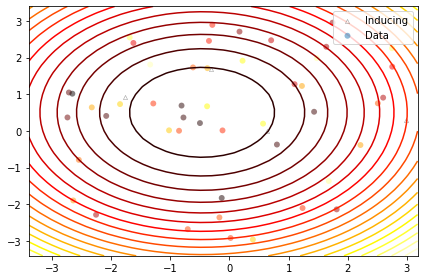

In [9]:
m.plot()

In [10]:
deep_rbf = deepRBF(input_dim=2)

In [11]:
#m2 = GPy.models.GPRegression(X, Y, deep_rbf)
m2 = GPy.models.SparseGPRegression(X, Y, kernel=deep_rbf, num_inducing=num_inducing)

In [12]:
m2['.*len'] = .1

In [13]:
m2.checkgrad()

False

In [14]:
m2.optimize()
#m2.optimize('tnc', messages=1, max_iters=max_iters)

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning:invalid value encountered in power


 /Users/luck1226/anaconda3/lib/python3.6/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'inducing': <matplotlib.collections.PathCollection at 0x10f651a58>,
 'dataplot': [<matplotlib.collections.PathCollection at 0x10f651dd8>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x10f651e80>]}

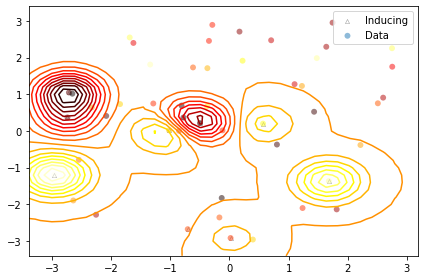

In [15]:
m2.plot()

In [16]:
print(m2)


Name : sparse_gp
Objective : 55.5453696093377
Number of Parameters : 24
Number of Optimization Parameters : 24
Updates : True
Parameters:
  sparse_gp.               |                value  |  constraints  |  priors
  inducing_inputs          |              (10, 2)  |               |        
  deep_rbf.variance1       |  0.12902871238232794  |               |        
  deep_rbf.lengtscale      |   0.3910489279942112  |               |        
  deep_rbf.variance2       |   0.6467350551276398  |               |        
  Gaussian_noise.variance  |   0.9002295373932625  |      +ve      |        


In [17]:
from sklearn.datasets import load_boston
X_b, y_b = load_boston(return_X_y=True)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2)

In [19]:
X_train.shape

(404, 13)

In [20]:
y_train.shape

(404,)

In [21]:
m_boston = GPy.models.GPRegression(X_train, np.array(y_train).reshape(-1,1))

In [22]:
m_boston.optimize()

In [23]:
y_pred=m_boston.predict(X_test)[0]

In [24]:
rms_boston_gp = np.sqrt(np.var(np.array(y_test).reshape(-1,1)-y_pred))
print(rms_boston_gp)

3.0458830727332704


In [25]:
d_rbf = deepRBF(input_dim=X_train.shape[1])
m_boston_2 = GPy.models.GPRegression(X_train, np.array(y_train).reshape(-1,1),d_rbf)

In [26]:
m_boston_2.optimize()

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning:invalid value encountered in power


In [27]:
y_pred2 = m_boston_2.predict(X_test)[0]

In [28]:
rms_boston_d = np.sqrt(np.var(np.array(y_test).reshape(-1,1)-y_pred2))
print(rms_boston_d)

7.532529661595388


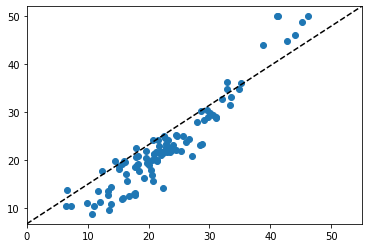

In [51]:
#np.array(y_pred).reshape()

plt.scatter(y_pred,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.show()

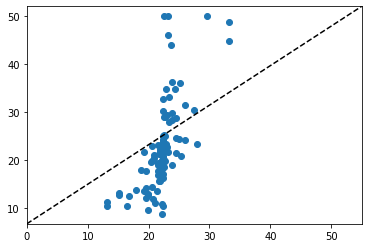

In [52]:
plt.scatter(y_pred2,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.show()

In [31]:
y_ptrain =  m_boston.predict(X_train)[0]

In [32]:
print(np.sqrt(np.var(y_train-y_ptrain)))

12.519750176494735


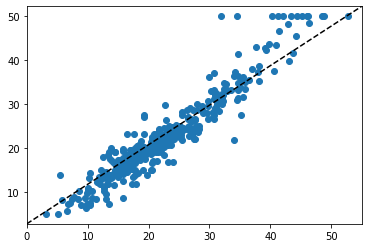

In [53]:
plt.scatter(y_ptrain,y_train)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.show()

In [34]:
y_ptrain2 = m_boston_2.predict(X_train)[0]

In [35]:
print(np.sqrt(np.var(y_train-y_ptrain2)))

10.293049362437538


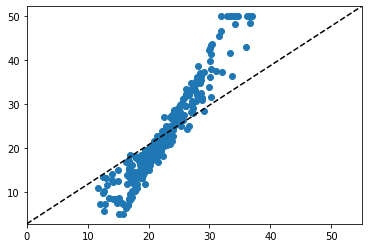

In [54]:
plt.scatter(y_ptrain2,y_train)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.show()

In [37]:
kern_rq = GPy.kern.RatQuad(input_dim=X_train.shape[1])
m_boston_3 = GPy.models.GPRegression(X_train, np.array(y_train).reshape(-1,1),kern_rq)

In [38]:
m_boston_3.optimize()

In [39]:
y_pred3 = m_boston_3.predict(X_test)[0]
y_ptrain3 = m_boston_3.predict(X_train)[0]

In [40]:
print(np.sqrt(np.var(y_train-y_ptrain3)))

12.519748697369142


In [41]:
print(np.sqrt(np.var(y_test-y_pred3)))

12.40600771671555


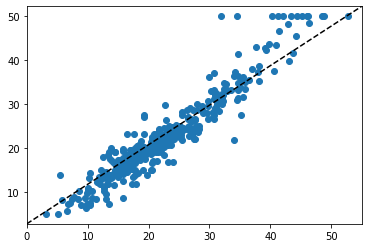

In [55]:
plt.scatter(y_ptrain3,y_train)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.show()

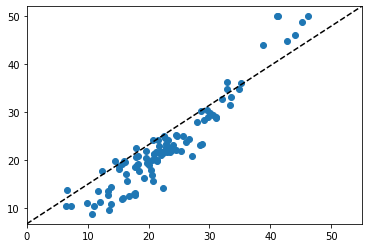

In [56]:
plt.scatter(y_pred3,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.show()

In [44]:
def compute_nll(y, mf, vf):
    y = y.reshape((y.shape[0],))
    ll = -0.5 * np.log(2 * np.pi * vf) - 0.5 * (y - mf)**2 / vf
    nll = -ll
    return np.mean(nll)

In [45]:
m1, v1 = m_boston.predict(X_train)
print(compute_nll(y_train,m1,v1))

8.56262800558314


In [46]:
m1t, v1t = m_boston.predict(X_test)
print(compute_nll(y_test,m1t,v1t))

8.245796624313167


In [47]:
m2, v2 = m_boston_2.predict(X_train)
print(compute_nll(y_train,m2,v2))

4.079485402015805


In [48]:
m2t, v2t = m_boston_2.predict(X_test)
print(compute_nll(y_test,m2t,v2t))

3.8549817344342308


In [49]:
m3, v3 = m_boston_3.predict(X_train)
print(compute_nll(y_train,m3,v3))

8.562595496425594


In [50]:
m3t, v3t = m_boston_3.predict(X_test)
print(compute_nll(y_test,m3t,v3t))

8.245768167395232


In [57]:
import deepgp

In [62]:
hidden = 1
m_deep = deepgp.DeepGP([1,hidden,X_train.shape[1]],Y=np.array(y_train).reshape(-1,1), X=X_train, inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(X_train.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)

In [64]:
for layer in m_deep.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m_deep.optimize(messages=True,max_iters=10000)

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [65]:
md, vd = m_deep.predict(X_train)
print(compute_nll(y_train,md,vd))

3.637749892180343


In [66]:
mdt, vdt = m_deep.predict(X_test)
print(compute_nll(y_test,mdt,vdt))

3.6362364972138876


In [67]:
print(np.sqrt(np.var(y_train-md)))

9.190831378114774


In [68]:
print(np.sqrt(np.var(y_test-mdt)))

9.174062917343669


In [69]:
from sklearn.metrics import mean_squared_error

In [70]:
print(mean_squared_error(y_train,y_ptrain))

8.659977889189411


In [71]:
print(mean_squared_error(y_train,y_ptrain2))

24.058966769855726


In [72]:
print(mean_squared_error(y_train,y_ptrain3))

8.660009656461787


In [73]:
print(mean_squared_error(y_test,y_pred))

9.286076891976723


In [74]:
print(mean_squared_error(y_test,y_pred2))

57.05199109577065


In [75]:
print(mean_squared_error(y_test,y_pred3))

9.286047364440599


In [76]:
print(mean_squared_error(y_test,mdt))

84.22788190229438


In [77]:
print(mean_squared_error(y_train,md))

84.47138364088842


In [78]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [92]:
print(rmse(y_test,m1t))

12.40636043655401


In [89]:
print(rmse(y_test,m2t))

9.653236723337216


In [90]:
print(rmse(y_test,m3t))

12.40635728281


In [82]:
print(rmse(y_test,mdt))

9.177574946699943


In [83]:
print(rmse(y_train,y_ptrain))

12.519750176704369


In [84]:
print(rmse(y_train,y_ptrain2))

10.294003992726983


In [85]:
print(rmse(y_train,y_ptrain3))

12.519748697578729


In [86]:
print(rmse(y_train,md))

9.19083149888455
